# 1. Setup the Environment

Transformers: For loading and fine-tuning the pre-trained RoBERTa model.

Datasets: For loading the MasakhaNER dataset.

Seqeval: For evaluating NER tasks (accuracy, precision, recall, F1-score).

In [ ]:
pip install transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=4728bd547eb240415777672954109e5baecc26cc61bc2e3efe4f78a95444d30e
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


# Load the Dataset
Load the MasakhaNER dataset, which contains Swahili text annotated with named entities.

In [ ]:
import numpy as np
import pandas as pd

from datasets import load_dataset

# Load the MasakhaNER dataset
dataset = load_dataset("masakhaner", "swa")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

masakhaner.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

The repository for masakhaner contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/masakhaner.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/2109 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/604 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2109
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 300
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 604
    })
})


In [ ]:
# Print the first five elements separately
for i in range(10):
    print(dataset["train"][i])

{'id': '0', 'tokens': ['Wizara', 'ya', 'afya', 'ya', 'Tanzania', 'imeripoti', 'Jumatatu', 'kuwa', ',', 'watu', 'takriban', '14', 'zaidi', 'wamepata', 'maambukizi', 'ya', 'Covid', '-', '19', '.'], 'ner_tags': [3, 4, 4, 4, 4, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'id': '1', 'tokens': ['Walioambukizwa', 'wote', 'ni', 'raia', 'wa', 'Tanzania', ',', '13', 'wakiwa', 'Dar', '-', 'es', '-', 'salaam', 'na', 'mmoja', 'mjini', 'Arusha', '.'], 'ner_tags': [0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 6, 6, 6, 6, 0, 0, 0, 5, 0]}
{'id': '2', 'tokens': ['Wizara', 'ya', 'afya', 'imeripoti', 'kwamba', 'juhudi', 'za', 'kufuatilia', 'watu', 'waliokuwa', 'karibu', 'na', 'wagonjwa', 'zinaendelea', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'id': '3', 'tokens': ['Wakati', 'wa', 'maadimisho', 'ya', 'pasaka', ',', 'wakristo', 'walikusanyika', 'kanisani', 'kwa', 'maombi', 'bila', 'kuzingatia', 'ushauri', 'wa', 'wataalam', 'wa', 'afya', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Check the unique tags in the dataset to create a label map
unique_tags = set(tag for tags in dataset["train"]["ner_tags"] for tag in tags)
print(unique_tags)

# Create a mapping for these labels (example)
label2id = {0: "O", 3: "PER", 4: "LOC", 5: "ORG", 6: "MISC", 7: "DATE"}  # Adjust based on your inspection
id2label = {v: k for k, v in label2id.items()}

print(label2id)


{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0: 'O', 3: 'PER', 4: 'LOC', 5: 'ORG', 6: 'MISC', 7: 'DATE'}


# Preprocess the Data
Convert the dataset into a format suitable for the castorini/afriberta_large model. This involves tokenizing the text and aligning the labels with the tokenized input.
Explanation of add_prefix_space=True
Why is it needed? castorini/afriberta_large tokenizers treat spaces as part of the tokenization process. When working with pretokenized inputs (e.g., a list of words), the tokenizer needs to know that each word is prefixed with a space (except the first word). Setting add_prefix_space=True ensures that the tokenizer correctly handles this.

When to use it? Always use add_prefix_space=True when your input is already split into words or tokens (e.g., examples MasakhaNER dataset).

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForTokenClassification
from datasets import Dataset

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_large")

# Define the tokenization function
def tokenize_and_align_labels(examples):
    """
    Tokenize the dataset and align labels with tokenized input.
    Preserve the original 'tokens' field for later use.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"],  # Assuming 'tokens' contains the list of words
        truncation=True,
        padding="max_length",
        max_length=64,
        is_split_into_words=True
    )

    # Align labels with tokenized input
    labels = []
    for i, label in enumerate(examples["ner_tags"]):  # Assuming 'ner_tags' contains the labels
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special token (e.g., [CLS], [SEP])
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # New word
            else:
                label_ids.append(-100)  # Subword of the same word
            previous_word_idx = word_idx

        labels.append(label_ids)

    # Add the original 'tokens' field to the tokenized dataset
    tokenized_inputs["tokens"] = examples["tokens"]
    tokenized_inputs["labels"] = labels

    return tokenized_inputs

# Assuming dataset is a Hugging Face Dataset object
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2109 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/604 [00:00<?, ? examples/s]

In [ ]:
# Check the result after tokenization
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2109
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 604
    })
})


# Prepare the Dataset for PyTorch
Make sure your dataset is properly formatted for the Trainer:

In [ ]:
# Set the format to PyTorch tensors for the required columns
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

# Check the format of the dataset after setting
print(tokenized_datasets)


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2109
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 604
    })
})


# Model and Training Arguments

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

# Load the model
model = AutoModelForTokenClassification.from_pretrained(
    "castorini/afriberta_large",
    num_labels=len(dataset["train"].features["ner_tags"].feature.names)
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",               # Save directory
    evaluation_strategy="epoch",         # Evaluate after each epoch
    save_strategy="epoch",               # Save model after each epoch
    logging_dir="./logs",                # Directory for logs
    logging_steps=100,                   # Log every 100 steps
    per_device_train_batch_size=16,      # Batch size for training
    per_device_eval_batch_size=32,       # Batch size for evaluation
    num_train_epochs=5,                  # Total number of epochs
    learning_rate=5e-5,                  # Learning rate
    weight_decay=0.01,                   # Weight decay for regularization
    load_best_model_at_end=True,         # Load the best model at the end
    metric_for_best_model="accuracy",    # Use accuracy for selecting the best model
)

pytorch_model.bin:   0%|          | 0.00/503M [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from pprint import pprint

pprint(tokenized_datasets["train"][0])


{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([    0,  2718,   268,  3064,   268,   659,   661, 15984, 15536,   364,
          261,   262,   640, 17817,   261,   267,   290,   720, 44390, 18656,
          268,  1127,   339,   261,   267,   295,   261,   263,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1]),
 'labels': tensor([-100,    3,    4,    4,    4,    4,    0, -100,    7,    0,    0, -100,
           0,    0,    0, -100, -100,    0,    0,    0,    0,    0,    0,    0,
        -100, -100,    0, -100, -100, -100, -100, -100, -100, -100, -100

# Evaluation Metrics

In [ ]:
pip install evaluate

model.safetensors:   0%|          | 0.00/503M [00:00<?, ?B/s]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 495.0 kB/s eta 0:00:00


In [ ]:
pip install seqeval

In [ ]:
import numpy as np
import evaluate

# Load the seqeval metric
metric = evaluate.load("seqeval")

# Extract label names
label_names = dataset["train"].features["ner_tags"].feature.names  # Ensure this exists

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Convert predictions and labels to tag names
    true_labels = [
        [label_names[l] for l in label if l != -100]
        for label in labels
    ]

    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Compute seqeval metrics
    results = metric.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [ ]:
print(compute_metrics((np.random.rand(5, 128, len(label_names)), np.random.randint(0, len(label_names), (5, 128)))))


{'precision': 0.15274949083503056, 'recall': 0.14763779527559054, 'f1': 0.15015015015015015, 'accuracy': 0.1}


# Initialize the Trainer

In [ ]:
from transformers import Trainer, DataCollatorForTokenClassification

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line to compute accuracy, precision, recall, and F1
)




<ipython-input-15-5c46baf05708>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Verify Dataset Dimensions :
After applying the above changes, verify that the dataset has consistent dimensions by inspecting the tokenized data.

In [ ]:
print(tokenized_datasets["train"].features)

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'], id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


# Fine tuning

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zda24m003 (zda23m016-iit-madras-zanzibar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.226700,0.075000,0.849354,0.916409,0.881608,0.974499
2,0.063300,0.071121,0.868343,0.908669,0.888048,0.977221
3,0.041000,0.087900,0.853198,0.908669,0.880060,0.972206
4,0.011500,0.102961,0.857143,0.919505,0.887229,0.970917
5,0.008200,0.104186,0.849275,0.907121,0.877246,0.971347


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

TrainOutput(global_step=660, training_loss=0.05705260530565724, metrics={'train_runtime': 8784.196, 'train_samples_per_second': 1.2, 'train_steps_per_second': 0.075, 'total_flos': 287042028082560.0, 'train_loss': 0.05705260530565724, 'epoch': 5.0})

In [ ]:
# Evaluate the model on the validation dataset
eval_results = trainer.evaluate()



# Print evaluation metrics
print(f"Validation Accuracy: {eval_results['eval_accuracy']}")
print(f"Validation precision: {eval_results['eval_precision']}")
print(f"Validation recall: {eval_results['eval_recall']}")
print(f"Validation F1 Score: {eval_results['eval_f1']}")


# Save the best model after training
trainer.save_model("./best_model")


Validation Accuracy: 0.9772206303724928
Validation precision: 0.8683431952662722
Validation recall: 0.9086687306501547
Validation F1 Score: 0.8880484114977307


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


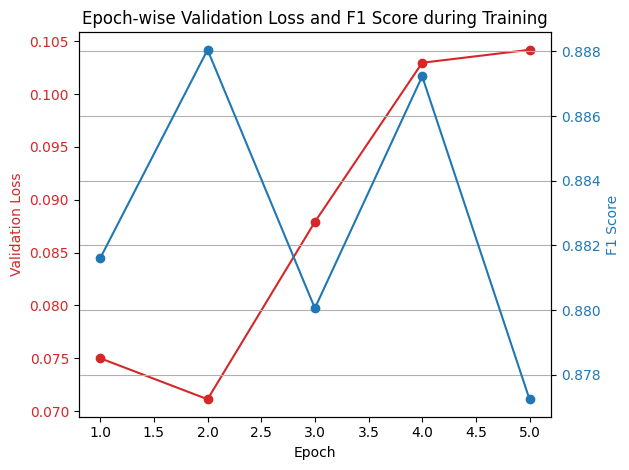

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
epochs = [1, 2, 3, 4, 5]
validation_loss = [0.075000, 0.071121, 0.087900, 0.102961, 0.104186]
f1_score = [0.881608, 0.888048, 0.880060, 0.887229, 0.877246]

# Plotting the data
fig, ax1 = plt.subplots()

# Plotting Validation Loss on the left y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss', color='tab:red')
ax1.plot(epochs, validation_loss, color='tab:red', label='Validation Loss', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Creating a second y-axis to plot F1 Score
ax2 = ax1.twinx()
ax2.set_ylabel('F1 Score', color='tab:blue')
ax2.plot(epochs, f1_score, color='tab:blue', label='F1 Score', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Adding a title and showing the grid
plt.title('Epoch-wise Validation Loss and F1 Score during Training')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


Evaluation on Test Dataset:

In [ ]:
test_results = trainer.evaluate(tokenized_datasets["test"])
print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test Precision: {test_results['eval_precision']}")
print(f"Test Recall: {test_results['eval_recall']}")
print(f"Test F1 Score: {test_results['eval_f1']}")


Test Accuracy: 0.9740672135485579
Test Precision: 0.8543771043771043
Test Recall: 0.8765112262521589
Test F1 Score: 0.8653026427962489


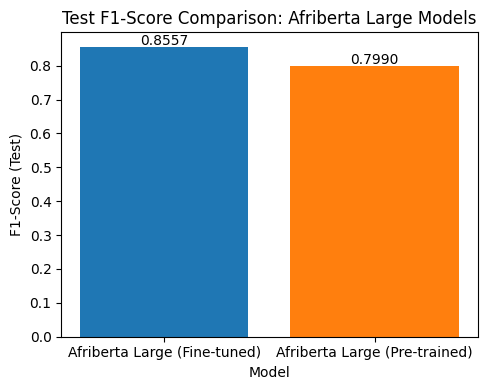

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
models = ['Afriberta Large (Fine-tuned)', 'Afriberta Large (Pre-trained)']
test_f1_scores = [0.8557, 0.7990]

# Creating the bar plot
plt.figure(figsize=(5, 4))
plt.bar(models, test_f1_scores, color=['tab:blue', 'tab:orange'])

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('F1-Score (Test)')
plt.title('Test F1-Score Comparison: Afriberta Large Models')

# Displaying the F1-score on top of the bars
for i, score in enumerate(test_f1_scores):
    plt.text(i, score + 0.005, f'{score:.4f}', ha='center', color='black')

# Show the plot
plt.tight_layout()
plt.show()


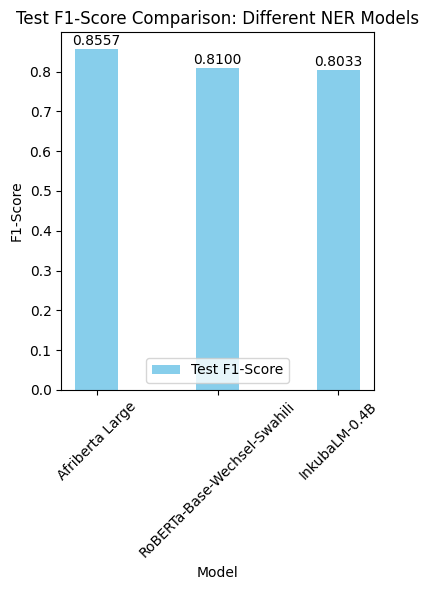

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table (only Test F1-Score now)
models = ['Afriberta Large', 'RoBERTa-Base-Wechsel-Swahili', 'InkubaLM-0.4B']
test_f1_scores = [0.8557, 0.81, 0.8033]

# Create an index for the models and bar width
index = np.arange(len(models))
bar_width = 0.35

# Plotting the bars for Test F1-Score
plt.figure(figsize=(4, 6))

# Plotting Test F1-Score
# Filter out None values for test F1-Score (use 0 for models with no test F1-Score)
test_f1_scores_filtered = [score if score is not None else 0 for score in test_f1_scores]

# Create the bar plot for Test F1-Scores with skyblue color
plt.bar(index, test_f1_scores_filtered, bar_width, label='Test F1-Score', color='skyblue')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('Test F1-Score Comparison: Different NER Models')
plt.xticks(index, models, rotation=45)
plt.legend()

# Displaying F1-scores on top of bars for clarity
for i in range(len(models)):
    if test_f1_scores[i] is not None:  # Only display for models with a score
        plt.text(index[i], test_f1_scores_filtered[i] + 0.01, f'{test_f1_scores[i]:.4f}', ha='center', color='black')

# Show the plot
plt.tight_layout()
plt.show()


# Save the Best Model
After training, save your fine-tuned model:

In [ ]:
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/sentencepiece.bpe.model',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

In [ ]:
print(tokenized_datasets["test"].features)

# Extract 500 Named Entities and Saved in a Excel for Verification by Swahili Speakers ( uploaded on github)
From the test set predictions, extract 500 named entities. These entities should represent a diverse sample of the categories (e.g., PERSON, LOCATION, ORGANIZATION, etc.) to ensure comprehensive validation.

In [ ]:
import re
import pandas as pd
import numpy as np

def extract_entities_from_predictions(predictions, tokenized_data, tokenizer):
    extracted_entities = []
    entity_labels = tokenized_data.features["ner_tags"].feature.names

    for prediction, example in zip(predictions, tokenized_data):
        input_ids = example["input_ids"]  # Tokenized input IDs
        tokens = tokenizer.convert_ids_to_tokens(input_ids)  # Convert token IDs back to words

        current_entity_tokens = []
        current_entity_type = None

        for idx, (pred, input_id) in enumerate(zip(prediction, input_ids)):
            # Skip special tokens
            if input_id in [tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id]:
                continue

            # Ensure prediction is within valid range
            if pred >= len(entity_labels):
                continue  # Skip invalid label indices

            label = entity_labels[pred]
            word = tokens[idx]

            # Handle subwords (remove special characters like "▁" or "##")
            word = re.sub(r"^▁|##", "", word)  # SentencePiece uses "▁", BERT uses "##"

            if label.startswith("B-"):  # Beginning of an entity
                if current_entity_tokens:
                    extracted_entities.append((" ".join(current_entity_tokens), current_entity_type))
                current_entity_tokens = [word]
                current_entity_type = label.split("-")[-1]
            elif label.startswith("I-") and current_entity_tokens:  # Inside the same entity
                current_entity_tokens.append(word)
            else:  # Outside entity
                if current_entity_tokens:
                    extracted_entities.append((" ".join(current_entity_tokens), current_entity_type))
                current_entity_tokens = []
                current_entity_type = None

        # Add last entity if exists
        if current_entity_tokens:
            extracted_entities.append((" ".join(current_entity_tokens), current_entity_type))

    return extracted_entities  # Return all entities (do not slice here)


# Ensure predictions are calculated per batch to prevent memory issues
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])  # Assuming you have a trainer object and test set
# Convert predictions to tag indices safely
predictions = np.argmax(predictions, axis=2)

# Ensure dataset and predictions match in size
if len(predictions) != len(tokenized_datasets["test"]):
    raise ValueError("Mismatch between predictions and dataset size!")

# Extract named entities (pass tokenizer)
sampled_entities = extract_entities_from_predictions(predictions, tokenized_datasets["test"], tokenizer)

# Ensure at least 500 entities are printed if available
# Debugging step for entity, entity_type in sampled_entities[:min(500, len(sampled_entities))]:
# Print only available entities
for entity, entity_type in sampled_entities[:min(500, len(sampled_entities))]:
    print(f"Entity: {entity}, Type: {entity_type}")

# Create a DataFrame to save to Excel
entities_df = pd.DataFrame(sampled_entities, columns=["Entity", "Type"])

# Save the DataFrame to an Excel file
output_file = "named_entities.xlsx"
entities_df.to_excel(output_file, index=False)

print(f"Named entities saved to {output_file}")


Entity: Yoweri Museveni, Type: PER
Entity: wiki, Type: DATE
Entity: juma nne, Type: DATE
Entity: Museveni, Type: PER
Entity: Museveni, Type: PER
Entity: siku  2, Type: DATE
Entity: Museveni, Type: PER
Entity: Museveni, Type: PER
Entity: Uganda, Type: LOC
Entity: Ru, Type: PER
Entity: hakana Ru gun da, Type: PER
Entity: Sam Ku te sa, Type: PER
Entity: Uganda, Type: LOC
Entity: Uganda, Type: LOC
Entity: Uganda, Type: LOC
Entity: Museveni, Type: PER
Entity: Jumanne, Type: DATE
Entity: Uganda, Type: LOC
Entity: China, Type: LOC
Entity: Afrika, Type: LOC
Entity: China, Type: LOC
Entity: Museveni, Type: PER
Entity: Marekani, Type: LOC
Entity: Uganda, Type: LOC
Entity: Marekani, Type: LOC
Entity: Museveni, Type: PER
Entity: Uganda, Type: LOC
Entity: Jumanne, Type: DATE
Entity: Uganda, Type: LOC
Entity: Dubai, Type: LOC
Entity: Ken nes Bw ire, Type: PER
Entity: Washington DC, Type: LOC
Entity: Jumamosi, Type: DATE
Entity: Baghdad, Type: LOC
Entity: Iran, Type: LOC
Entity: Iraqi, Type: LOC
Enti